# Tutorial for the ESPClust package

This is a tutorial showing how to use functions from the ESPClust library. ESPClust is applied to synthetic data and metabolomics data.

Load required libraries:

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as smapi

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

# generate random Gaussian values
# https://numpy.org/doc/1.16/reference/routines.random.html
from numpy.random import seed
from numpy.random import randn
from numpy.random import uniform #random.uniform(low=0.0, high=1.0, size=None)
from numpy.random import normal  #normal([loc, scale, size])
from numpy.random import exponential   #exponential([scale, size])
from numpy.random import lognormal   #lognormal([mean, sigma, size])

#Probability distributions 
# https://docs.scipy.org/doc/scipy/reference/stats.html
from scipy.stats import norm   # norm.pdf(x, loc=0, scale=1)
from scipy.stats import lognorm   # lognorm.pdf(x, s, loc=0, scale=1)

import ESPClust as ESPClust

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Synthetic Data

We constructed a dataset with 100 observations for each class of a dichotomous outcome $Y \in \{0,1\}$. Each observation includes 30 omics variables, $\{X_1, X_2, \dots, X_{30}\}$, and two effect modifiers, $\{Z_1, Z_2\}$. The values of $Z_1$ and $Z_2$ were drawn uniformly from $[0,1]$.

The covariate space $\{Z_1, Z_2\}$ is divided into two regions with distinct associations between the omics variables and the outcome:

- **Region A:** Defined by $Z_1 \leq 0.5$ or $Z_2 \leq 0.5$.
- **Region B:** Defined by $Z_1 > 0.5$ and $Z_2 > 0.5$.

To make the regions more realistic, the boundary between them was smoothed, creating a gradual transition in membership probabilities near the thresholds.

For observations with $Y = 0$, the omics variables were generated independently of $\{Z_1, Z_2\}$. These variables were drawn as $X_m \sim N(2, 0.5^2)$.

For observations with $Y = 1$:
- **In Region A:** The omics variables followed the same distribution as $Y = 0$, indicating no statistical association between the omics variables and the outcome in this region.
- **In Region B:** The 30 omics variables were divided into three mutually exclusive random sets, each containing 10 variables. Within each set, the omics variables were drawn from $X_m \sim N(\bar{X}_m, 0.5^2)$, with $\bar{X}_m = 2, 2.7,$ and $1.3$ for the three sets, respectively.


### Generating and visualizing the dataframe

In [2]:
import random

# Smooth transition between regions A and B: 2D Sigmoid function centered at (midpoint1, midpoint2) with tunable slopes
def sigmoid_2d(z1, z2, midpoint1=0.5, midpoint2=0.5, slope1=10, slope2=10):
    # Apply sigmoid transformation to each variable
    sigmoid_z1 = 1 / (1 + np.exp(-slope1 * (z1 - midpoint1)))
    sigmoid_z2 = 1 / (1 + np.exp(-slope2 * (z2 - midpoint2)))
    
    # Combine the two sigmoids (here, we take the product to create a smooth 2D transition)
    return np.sqrt(sigmoid_z1 * sigmoid_z2) #sigmoid_z1 * sigmoid_z2 #np.sqrt(sigmoid_z1 * sigmoid_z2)

#- Set a fixed random seed
np.random.seed(2)

offset = 2 # Baseline for the effect size in region A without effect modification
e1= 0.7 # Effect size difference between classes in region B with effect modification
M=30  # Number of 'omics' variables

# Number of examples in each class of the dichotomous outcome
n0=100
n1=100

# slope for the sigmoid function introducing a fuzzy separation in terms of z
slope = 50

# standard deviation of the variables x_0, x_1, ...
sigma0=0.5
sigma1=0.5

##--- Random sample sizes for metabolites
n00 = int(M/3)  # Number of zeros
n11 = n00  # Number of ones
n22 = M-n00-n11

# Create the array of zeros and ones
ZeroOnes = np.array([-1] * n22 + [1] * n11 + [0] * n00)
# Shuffle the array to make it random
np.random.shuffle(ZeroOnes)
eMinus = [offset for i in range(M)]  # Mean effect size in group A
ePlus = ZeroOnes*e1+offset # Mean effect size in group B

###------ effect modifier ~ U(0,1) ----
z1max=1
z1=uniform(0,z1max,n0+n1)
z2max=1
z2=uniform(0,z2max,n0+n1)

# Points to divide regions A and B
fz1=0.5
fz2=0.5

# Omics variables 
variables = np.zeros([n0+n1,M])
# A sign variable to know to which cluster each point belongs in terms of (z1,z2)
esign = np.zeros(n0+n1)

for sample in range(n0,n0+n1):
    ## Smooth separation between regions A and B
    prob_ePlus = 1-sigmoid_2d(z1[sample], z2[sample], midpoint1=fz1*z1max, midpoint2=fz2*z2max, slope1=slope, slope2=slope)
    # Select either ePlus or eMinus based on probability
    r = np.random.rand()
    es = eMinus
    esign[sample] = -1
    if r > prob_ePlus:
        es = ePlus
        esign[sample] = 1
                
    for m in range(M):
        variables[sample,m] = normal(es[m],sigma1)  # class 0

for sample in range(n0):
    for m in range(M):
        variables[sample,m] = normal(offset,sigma0)

df_esign = pd.DataFrame({'z1': z1[n0:], 'z2': z2[n0:], 'esign': esign[n0:]})

### --- Data dataframe ---
iid=list(range(n0+n1))
outcome=[0 for i in range(n0)]+[1 for i in range(n1)]

# Creating a DataFrame
outcomeDF = pd.DataFrame({
    'iid': iid,
    'outcome': outcome
})

otherVariablesDF = pd.DataFrame({
    'iid': iid,
    'z1': z1,
    'z2': z2
})

variablesDF = pd.DataFrame(variables, columns=["X"+str(i+1) for i in range(M)])

data = pd.concat([variablesDF, otherVariablesDF['z1'],otherVariablesDF['z2'],outcomeDF['outcome']], axis=1)


Generated dataframe:

In [5]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,X26,X27,X28,X29,X30,z1,z2,outcome
0,2.041377,2.344729,1.739920,1.546461,0.541990,1.556853,1.918713,1.781907,1.259793,2.486369,...,1.571794,2.340135,2.539022,2.287198,2.711004,2.218291,2.010150,0.546207,0.861028,0
1,1.946476,1.570201,3.141873,2.886940,2.091951,1.306599,1.616167,2.223817,1.941540,2.216788,...,1.906734,1.775777,2.559992,2.427237,2.022982,3.130725,2.211283,0.407308,0.280860,0
2,1.685630,1.588822,1.957160,2.174928,1.051206,0.225438,1.637476,2.660958,3.089786,1.440099,...,1.790130,2.278065,1.591701,1.324890,2.125736,2.301329,1.617692,0.176985,0.125219,0
3,2.661281,2.313583,1.454358,2.199551,1.697706,1.580399,2.041829,2.565305,2.078891,2.129038,...,1.324364,1.915524,1.589548,2.084111,1.327323,2.337501,1.762091,0.969632,0.074261,0
4,1.627619,2.784455,2.232153,2.504844,1.471517,1.687157,2.604985,1.761786,2.308546,1.399564,...,1.586419,1.644914,2.126086,2.136088,1.303282,1.802823,1.819253,0.297018,0.325846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.760860,0.850180,1.953320,2.358067,1.784308,1.926638,1.656370,1.815270,1.052384,2.051061,...,2.572381,1.750715,2.833788,1.337828,2.039972,2.229348,1.522759,0.575779,0.708906,1
196,1.427625,1.772272,2.501025,1.186052,1.562252,2.967699,1.830032,1.736870,1.572580,2.529968,...,1.956238,2.086589,3.316428,1.459132,1.471707,1.958446,1.423703,0.418907,0.537307,1
197,1.605985,2.465547,1.924049,2.257773,3.228761,2.071632,1.135207,0.338593,1.703932,2.341667,...,1.855611,1.619086,2.609439,1.060405,2.379308,1.746312,2.096254,0.068599,0.180768,1
198,2.452127,1.465628,1.842360,1.939149,1.599303,1.045131,2.126388,1.489369,1.792615,2.311370,...,0.968270,1.963365,1.195050,1.973265,1.918999,2.166083,2.322127,0.097548,0.088649,1


Plot of the observations in the covariate space:

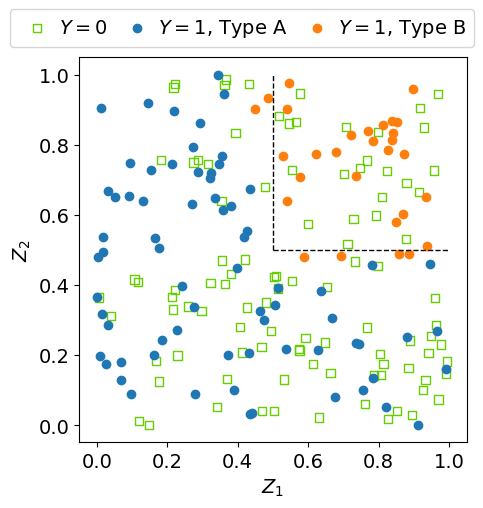

In [6]:
fig = plt.figure(figsize=(5,5))
font = {'size'   : 14}
plt.rc('font', **font)

data0 = data[data['outcome']==0]
plt.scatter(data0['z1'],data0['z2'],marker='s', facecolors='none', edgecolors='#66CD00',label='$Y=0$')

# Plot each class separately with different colors
colors = {0: '#0d0887', 1: '#f0f921'}  
#labels = {-1: 'Group A', 1: 'Group B'}
labels = [-1,1]
for group in labels:
    subset = df_esign[df_esign['esign'] == group]
    plt.scatter(subset['z1'], subset['z2'], label=labels[group])

# -- Group A region
plt.plot([0.5,1],[0.5,0.5],color = 'black', linestyle = '--', linewidth=1.0)
plt.plot([0.5,0.5],[0.5,1],color = 'black', linestyle = '--', linewidth=1.0)

plt.xlabel('$Z_1$')
plt.ylabel('$Z_2$')
plt.legend(['$Y=0$', '$Y=1$, Type A', '$Y=1$, Type B'], 
           loc='upper center', 
           bbox_to_anchor=(0.42, 1.15), 
           ncol=3, 
           handletextpad=0.1,  # Reduce space between legend marker and text
           columnspacing=0.5) # Reduce space between columns



Plot of the omics variables for three selected observations with differing outcomes and/or association type:

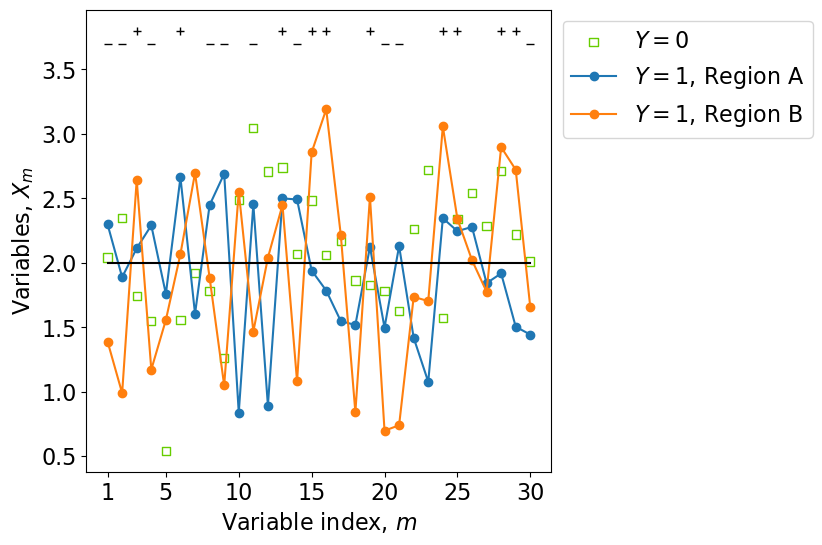

In [11]:
X_name=variablesDF.columns
Y_name='outcome'
confound_names = ['z1','z2']

fig = plt.figure(figsize=(6,6))
font = {'size'   : 16}
plt.rc('font', **font)

colors = {0: '#0d0887', 1: '#f0f921'}  

data0 = data[data["outcome"]==0]
plt.scatter(X_name,data0.loc[0][0:M],marker='s', facecolors='none', edgecolors='#66CD00',label="Y = 0")

data1=data[data["outcome"]==1]

data1Plus=data1[(data1['z1']>fz1)&(data1['z2']>fz2)]

data1Minus=data1[(data1['z1']<fz1)|(data1['z2']<fz2)]

plt.plot(X_name,data1Minus.loc[data1Minus.index[0]][0:M],'-o',label="Y=1, Region A")
plt.plot(X_name,data1Plus.loc[data1Plus.index[0]][0:M],'-o',label="Y=1, Region B")


plt.xticks(ticks=[i for i in [0,4,9,14,19,24,29]], labels= [i+1 for i in [0,4,9,14,19,24,29]])

# Plot significant variables
epos=[]
eneg=[]
xsig_pos=[]
xsig_neg=[]
for i in range(len(ePlus)):
    if ePlus[i]>offset:
        epos.append(3.8)
        xsig_pos.append(i)
    if ePlus[i]<offset:
        eneg.append(3.7)
        xsig_neg.append(i)
plt.plot(xsig_pos,epos,'+',c='black')
plt.plot(xsig_neg,eneg,'_',c='black')

# - standardised
#plt.plot((ePlus-np.mean(scaler.mean_))/np.mean(np.sqrt(scaler.var_)),'--',c='black')
#plt.plot(ePlus,'--',c='black')
plt.plot(eMinus,'-',c='black')

plt.xlabel('Variable index, $m$')
plt.ylabel('Variables, $X_m$')

### --- LEGEND
#plt.legend(['$Y=0$', '$Y=1$, Type A', '$Y=1$, Type B'], loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=5)  # ON TOP
plt.legend(['$Y=0$', '$Y=1$, Region A', '$Y=1$, Region B'], loc='upper left', bbox_to_anchor=(1, 1))  # UPPER ON RIGHT SIDE
#plt.legend()

### Creating a cover for the covariate space with gliding windows

We first use the function `window_parameters` to calculate suitable dimensions ($L$) and gliding steps ($\Delta$) for gliding windows in the dimensions of the covariate space spanned by $\{Z_1,Z_2\}$:

In [13]:
modifier_names = ['z1','z2']

explore_names= ['z1','z2']
data1=data[explore_names]
y=data['outcome']

nmin=20
CL=0.95

L,Delta = ESPClust.window_parameters(data1,nmin,CL)

print('L:',L,'Delta:',Delta)

L: [0.39972833621122, 0.38652306177589474] Delta: [0.16754455966374815, 0.1568977897690338]


We now use the `Homogeneous_Windows` lists `L` and `Delta` to create a grid-like structure which divides the covariate space into windows:

In [15]:
var_type=['c','c']  # `c`: continuous covariates Z1 and Z2
z0,Lw,win_dim,n_windows = ESPClust.Homogeneous_Windows(data,modifier_names,L,Delta,var_type)

print('win_dim:',win_dim,'n_windows:',n_windows)

win_dim: [6, 7] n_windows: 42


### Calculation of the ESP within windows

We use the function `effect_windows` to calculate the ESP within windows using univariate logistic regression with the function `effsize_logit_odds`. The function `effsize_logit_odds` is explicitly defined here to illustrate how functions to calculate effect sizes can be defined by the user depending on the data under consideration. In any case, `effsize_logit_odds` is already available in ESPClust and one could simply call it within the function `effect_windows` using `ESPClust.effsize_logit_odds`.

In [17]:
X_name=variablesDF.columns
Y_name='outcome'
confound_names = ['z1','z2']

def effsize_logit_odds(y, xdf):
    # Scale the features
    scaler = StandardScaler().fit(xdf)
    x_scaled = scaler.transform(xdf)
    
    # Fit logistic regression model
    model = LogisticRegression().fit(x_scaled, y)
    # Get the coefficient for the predictor variable of interest (last column in this case)
    odds_ratio = np.exp(model.coef_[0][-1])  # Exponentiate to get odds ratio
    
    return odds_ratio
    
esp_df_odds = ESPClust.effect_windows(data, X_name, Y_name, confound_names, modifier_names, z0, Lw, nmin, ESPClust.effsize_logit_odds)
esp_df = esp_df_odds

Variable 1 of 30, X1
Variable 2 of 30, X2
Variable 3 of 30, X3
Variable 4 of 30, X4
Variable 5 of 30, X5
Variable 6 of 30, X6
Variable 7 of 30, X7
Variable 8 of 30, X8
Variable 9 of 30, X9
Variable 10 of 30, X10
Variable 11 of 30, X11
Variable 12 of 30, X12
Variable 13 of 30, X13
Variable 14 of 30, X14
Variable 15 of 30, X15
Variable 16 of 30, X16
Variable 17 of 30, X17
Variable 18 of 30, X18
Variable 19 of 30, X19
Variable 20 of 30, X20
Variable 21 of 30, X21
Variable 22 of 30, X22
Variable 23 of 30, X23
Variable 24 of 30, X24
Variable 25 of 30, X25
Variable 26 of 30, X26
Variable 27 of 30, X27
Variable 28 of 30, X28
Variable 29 of 30, X29
Variable 30 of 30, X30


### Visualisation of the windows effect size

The dependence of the effect size of the association between an exposure (`variable`) and the outcome as a function of a covariate (`modifier`) can be plotted with the function `Eff_size_Windows_plot` 

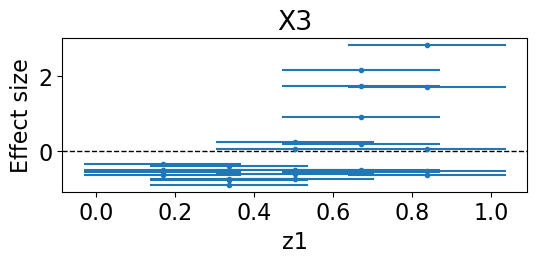

In [19]:
variable = X_name[2]
modifier = "z1"
no_effect_value = 0
errorbar = 'y'
ESPClust.Eff_size_Windows_plot(esp_df,variable,modifier,no_effect_value,errorbar)

### Clustering of windows according to their ESP

ESPClust provides several functions to analyse the clustering of windows

#### Clustering indices

The function `Clustering_indices` four clustering measures as a function of the number of clusters ($k \in \{2,3,\dots,k_{\max}\}$): Calinski-Harabasz, Davies-Bouldin, silhouette and inertia. 

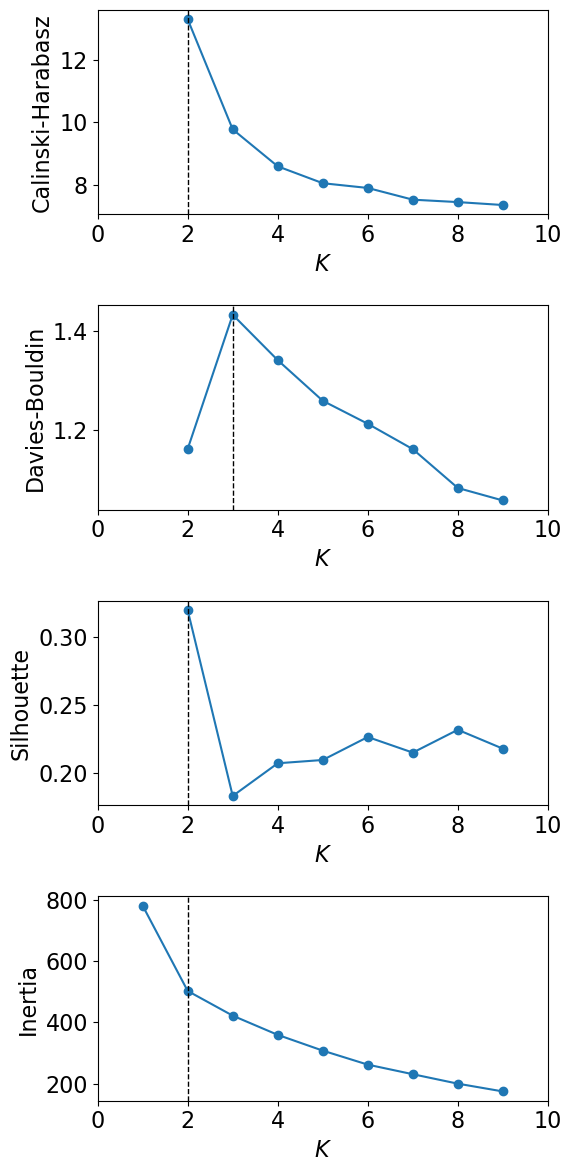

In [21]:
features_df = esp_df[X_name]
kmax = 10
cluster_method = "Agglomerate"  #"Kmeans"
plotYN = 'y'
index_vs_K_df,KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall = ESPClust.Clustering_indices(features_df,kmax,cluster_method,plotYN)

##### Outputs of `Clustering_indices`

- If `plotYN = "Y"`, the function `Clustering_indices` provides a plot for each of the clustering measures as a function of the number of clusters. A vertical dashed line indicates the optimal number of clusters for each of the measures.

- `Clustering_indices` provides a dataframe with the value of the clustering measures as a function of the number of clusters:

In [23]:
index_vs_K_df

,k,CH,DB,Sil,inertia
0,1,NaN,NaN,NaN,780.000000
1,2,13.284152,1.160844,0.319953,502.090009
2,3,9.776479,1.433372,0.183349,421.592308
3,4,8.599047,1.341120,0.207395,359.017293
4,5,8.061840,1.258613,0.209811,307.620874
5,6,7.910554,1.211903,0.226709,261.952549
6,7,7.537210,1.160371,0.215232,230.757514
7,8,7.460426,1.081494,0.232025,199.934543
8,9,7.367301,1.056090,0.218132,174.615203


- `Clustering_indices` also gives the optimal value of the number of clusters according to each of the clustering measures and the overall optimal:

In [25]:
KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall

(2, 3, 2, 2, 2)

#### Testing the statistical significance of `koptimal_overall` compared to a non-clustered data null hypothesis (no effect modification)

The function `Elbow_significance` tests the optimal number of clusters from the previous step against a dataset with uniform effect sizes without cluster structure:

In [27]:
nref = 2000 #2000  # Number of reference uniform datasets (2000)
kmax = 10
cluster_method = "Agglomerate"  # Or "Kmeans"
plotYN = 'y'
alpha=0.001

data = esp_df[X_name] #esp_df[X_name] #x_pca[:,:10] #x_pca #features_df #x_pca
    
features_df = data
k_test = koptimal_overall
DeltaObs, percentile, p_value, koptimal_overall2, reject_null = ESPClust.Elbow_significance(features_df,k_test,nref,cluster_method,alpha)
DeltaObs, percentile, p_value, koptimal_overall2, reject_null

(2.452396602892427, 0.7479746175447755, 0.0, 2, True)

In [29]:
KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall,koptimal_overall2

(2, 3, 2, 2, 2, 2)

#### Principal component visualisation of the clusters in the effect size space

The clustering of effect size windows can be visualised with `ESP_pca` using principal component analysis.

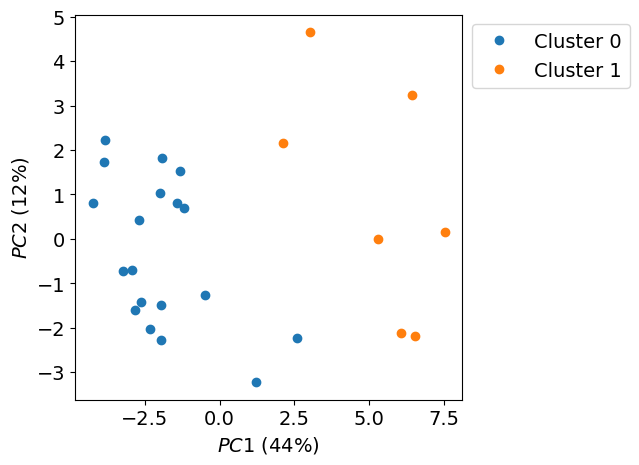

In [31]:
features_df = esp_df[X_name] 
n_clusters = koptimal_overall2 # Number of clusters to be coloured differently
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
pcomp_1=1 
pcomp_2=2
plotYN = "y"

x_pca,cumVar = ESPClust.ESP_pca(features_df,cluster_method,plotYN,pcomp_1,pcomp_2,n_clusters,clusterOrder)

##### Outputs

* If `plotYN = "y"`, a plot of the window lusters in the space spanned by the two selected principal components.
* `x_pca`: Coordinates of the projection of each feature on the principal component directions. 
* `cumVar`: array giving the cumulative explained variance for the principal components.

In [94]:
x_pca

array([[-4.24032822e+00,  7.95920463e-01,  3.82999702e+00,
         6.61626816e-01, -2.43123887e+00, -7.75442895e-01,
         2.13688120e+00,  5.89626569e-01,  4.02901172e-01,
         7.97431903e-01, -1.19440542e-01, -1.96055635e-01,
         1.69203386e-01,  5.42918750e-01, -7.25303931e-02,
        -6.58057442e-01, -1.33547189e-01,  8.70041809e-02,
         5.91229563e-03,  1.71063661e-01, -4.80508772e-02,
        -1.09427152e-02,  6.15509245e-02,  4.94715526e-02,
         4.88701175e-02, -1.11022302e-16],
       [-3.20681299e+00, -7.33375496e-01,  4.20333894e+00,
         4.17608498e-01,  2.58348286e-01,  7.65778355e-01,
         4.92304936e-01, -1.20155370e+00, -7.38497086e-01,
         4.18543254e-02, -2.14640042e-01, -1.83099532e-01,
        -5.53737495e-01, -7.62680793e-02,  7.69878275e-02,
         8.85168192e-01,  6.30160661e-01, -2.76962770e-01,
         1.01433745e-01, -7.71341511e-02, -3.03230781e-02,
        -1.75138455e-01,  3.25064371e-02, -3.27515342e-02,
         5.43

In [96]:
cumVar

array([0.43801843, 0.56233539, 0.67102772, 0.74547673, 0.80793892,
       0.85458034, 0.88262347, 0.90542485, 0.92330043, 0.93967765,
       0.95338436, 0.96266262, 0.9713219 , 0.97780427, 0.98324107,
       0.98767017, 0.99148491, 0.99457104, 0.99656675, 0.9982629 ,
       0.99898873, 0.99942731, 0.99973297, 0.99988021, 1.        ,
       1.        ])

#### Cluster label of each window

The function `Window_clusters_labels` finds clusters and assign a label to each cluster. It returns the cluster label for each window.

In [98]:
#------------------------------------
## ---- Labels of window clusters
#------------------------------------
n_clusters = koptimal_overall2
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
features_df = esp_df[X_name]
labels = ESPClust.Window_clusters_labels(features_df,n_clusters,cluster_method,clusterOrder)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1], dtype=int64)

#### Plot of the clusters in the covariate space

<Figure size 800x400 with 0 Axes>

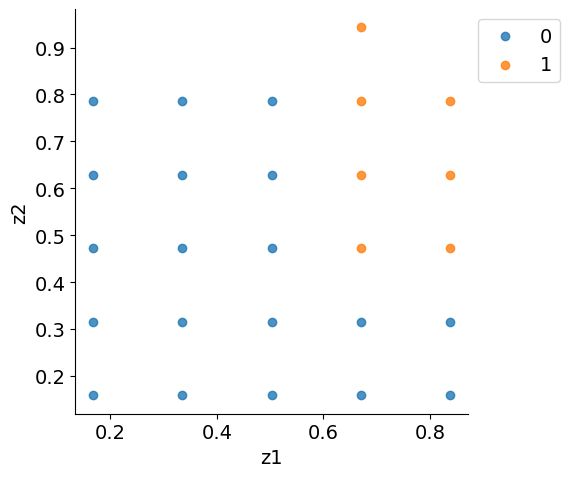

In [100]:
n_clusters = koptimal_overall2
clusterOrder=[0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
#%matplotlib widget
#%matplotlib inline
labelsDF = ESPClust.plot_clusters_CovSpace(esp_df,X_name,modifier_names,n_clusters,cluster_method,clusterOrder,L)

#### Cluster centroids

The coordinates of the centroids of the clusters, their dispersion and inertia of the clustering are provided by the function `Window_cluster_centroids`. 

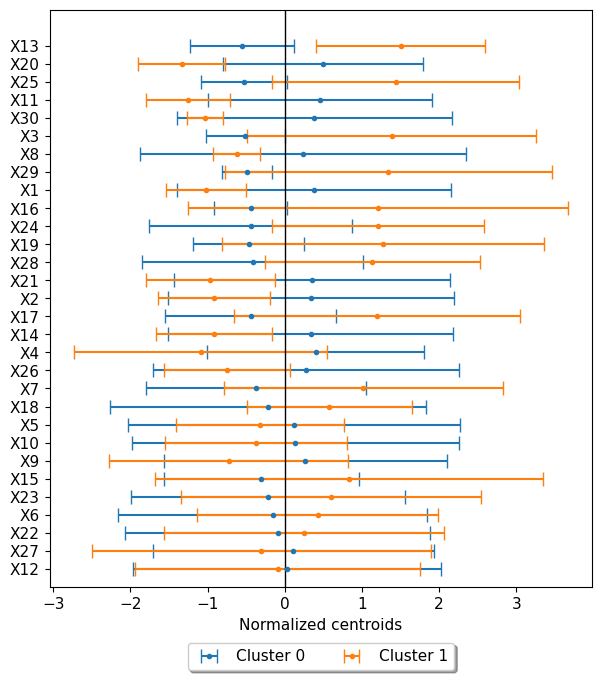

In [102]:
features_df = esp_df[X_name]
n_clusters = koptimal_overall2
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"

plot = 'errorbar' #'errorbar' #'none' #'lines', 'points', 'points-lines' #'errorbar'
scale_ErrorSD = 1.96
diff_sorted = "Y"

centroids,centroids_SD,inertia = ESPClust.Window_cluster_centroids(features_df,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)

## Metabolomics and insuline resistance

The association between 94 polar metabolites and insuline resistance of non-diabetic individuals is used as an example. We apply ESPClust to study BMI, sex, and gene richness as potential effect modifiers for the effect size profile corresponding to the association of the metabolites and insulin resistance.

### Data preparation

Read data for the key quantities used in the ESPClust method:
* Exposures, $\{X_1,X_2,\dots,X_M\}$. In this example, these are a set of $M=94$ metabolites stored below in a dataframe called `exposures`.
* Outcome $Y$. Here, the outcome is insulin resistance which is stored in the dataframe `outcome`.
* Covariates, $\{Z_1,Z_2,\dots,Z_M\}$. Here, BMI, sex and gene richness will be used. These are stored below in the dataframe `otherVariables`.

In addition, we read a file with names for the exposures which are useful for result interpretation. This is stored in the `annotation` dataframe.


In [5]:
# Specify the data of the files
outcomefile = "outcomeFile_Pedersen_NonDiabetic.csv" # File with outcome for each individual - Insulin resistance
exposuresfile = "Metabolites_Pedersen_NonDiabetic_known.csv" # Missing were zero in the original dataset - Transformed to true missing values (blanks)
annotationfile = "Annotation_metabolites_Pedersen_NonDiabetic_known.csv"
otherVariablesFile = "OtherVariables_Pedersen_NonDiabetic.csv"#"OtherVariables_Prepandemic_Nightingale_NewJul2022.csv"

# Files are read once the names have been specified
outcome = pd.read_csv("Data/" + outcomefile)
annotation = pd.read_csv("Data/" + annotationfile)
exposures = pd.read_csv("Data/" +  exposuresfile)
otherVariables = pd.read_csv("Data/" +  otherVariablesFile)


In [7]:
outcome

,iid,label
0,idv001,3.0
1,idv002,2.6
2,idv003,0.7
3,idv004,1.4
4,idv006,2.1
...,...,...
286,idv393,0.9
287,idv394,0.9
288,idv395,0.6
289,idv396,6.8


#### Data preliminary manipulation and cleaning

1. We set simpler names for the columns of the `otherVariables` dataframe. Here, `IR` stands for insulin resistance:

In [7]:
otherVariables.columns = ['StudyNumber','IR','BMI','Gene richness','Diabetes','sex']

In [9]:
otherVariables

,StudyNumber,IR,BMI,Gene richness,Diabetes,sex
0,idv001,3.0,39.1,679861.0,nonDiabetic,M
1,idv002,2.6,29.2,852354.0,nonDiabetic,M
2,idv003,0.7,24.0,983147.0,nonDiabetic,F
3,idv004,1.4,22.1,856417.0,nonDiabetic,F
4,idv006,2.1,32.1,586289.0,nonDiabetic,F
...,...,...,...,...,...,...
286,idv393,0.9,31.1,790764.0,nonDiabetic,F
287,idv394,0.9,28.2,950676.0,nonDiabetic,F
288,idv395,0.6,22.0,671107.0,nonDiabetic,M
289,idv396,6.8,36.1,795826.0,nonDiabetic,F


2. We drop individuals for whom there is no information on insulin resistance:

In [11]:
complete = ~otherVariables['IR'].isnull() # List of positions with complete IR
otherVariables = otherVariables[complete]
exposures = exposures[complete]
outcome = outcome[complete]

3. We encode the sex variable as an integer: Male -> 0, Female -> 1

In [13]:
otherVariables['sex'] = otherVariables['sex'].map({'M':0 , 'F':1})

4. Exposures transformation and cleaning:
- Metabolites whose concentration was missing for more than 20% of individuals are discarded. 
- Individuals who missed more than 20% of the metabolites are also discarded. 
- The remaining missing values for metabolites were imputed using k Nearest Neighbours with k=3.

In addition, exposures are transformed by adding 1 and taking the natural logarithm.

This is achieved through the ESPClust function `data_cleaning` which requires the following inputs:

- `featuresIn`: exposures dataframe.
- `Yin`: outcome.
- `thmissing`: A threshold value in [0,1]. Metabolites and individuals whose percentage of missing values is above this threshold Threshold for discarding metabolites or individuals with missing values.
- `otherVariables`: A dataframe with with covariates.
- `k_neighbours`: Number of neighbours for nearest neighbour imputation.
- `featTransform` (`None`, `Plus1Log`): If set to `None`, do not transform the data. If set to `Plus1Log`, transformation of the data by adding 1 and taking the natural logarithm.
- `plotYN`: If set to 'Y', plots are provided for the array of missing exposures and the missing percentage for exposures and individuals.

Missing metabolites: 2


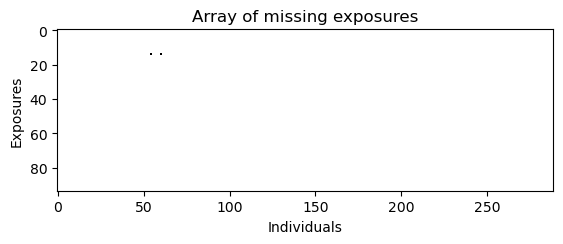

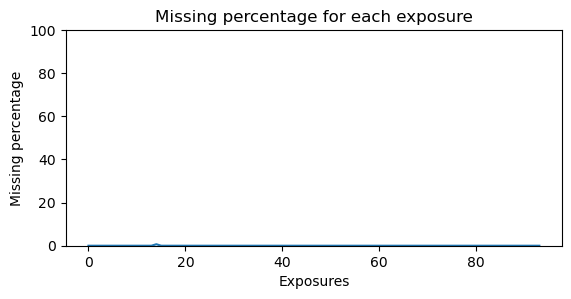

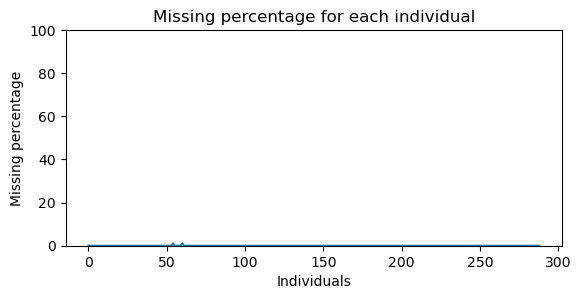

In [15]:
## - Data cleaning
featuresIn = exposures
Yin = outcome
thmissing = 0.2  # exposures that are missing for a proportion larger than this are dropped
k_neighbours = 3 # Value of k for kNN imputation
featTransform = "Plus1Log"
plotYN = 'Y'

featuresExtended, exposure_names = ESPClust.data_cleaning(featuresIn,Yin,otherVariables,annotation,thmissing,k_neighbours,featTransform,plotYN)

The function `data_cleaning` provides the following:

- `featuresExtended`: a dataframe with cleaned exposures together with columns from the `otherVariables` dataset and the `outcome` variable.
- `exposure_names`: Names of the exposures that were kept after cleaning. 

In [19]:
featuresExtended.columns

Index(['M_6_2.4.Dihydroxybutanoic.acid.', 'M_27_2.Hydroxybutyric.acid',
       'M_22_3.4.Dihydroxybutanoic.acid', 'M_25_3.Hydroxybutyric.acid',
       'M_28_Alanine', 'M_30_Arachidonic.acid', 'M_8_Aspartic.acid',
       'M_19_Cholesterol', 'M_9_Citric.acid', 'M_2_Glutamic.acid..3TMS',
       ...
       'M_250_alpha.Hydroxyvaleric.acid', 'M_43_beta.D.Galactofuranose',
       'M_298_beta.Hydroxyisovaleric.acid', 'outcome', 'StudyNumber', 'IR',
       'BMI', 'Gene richness', 'Diabetes', 'sex'],
      dtype='object', length=101)

In [20]:
exposure_names

Index(['M_6_2.4.Dihydroxybutanoic.acid.', 'M_27_2.Hydroxybutyric.acid',
       'M_22_3.4.Dihydroxybutanoic.acid', 'M_25_3.Hydroxybutyric.acid',
       'M_28_Alanine', 'M_30_Arachidonic.acid', 'M_8_Aspartic.acid',
       'M_19_Cholesterol', 'M_9_Citric.acid', 'M_2_Glutamic.acid..3TMS',
       'M_21_Glyceric.acid', 'M_10_Glycine', 'M_26_Isoleucine', 'M_23_Leucine',
       'M_14_Linoleic.acid', 'M_4_Methionine', 'M_13_Oleic.acid',
       'M_1_Ornithine', 'M_11_Palmitic.acid', 'M_3_Phenylalanine',
       'M_12_Proline', 'M_24_Serine', 'M_17_Stearic.acid', 'M_5_Threonine',
       'M_16_Tyrosine', 'M_20_Valine', 'M_212_11.Eicosenoic.acid',
       'M_162_1H.Indole.3.acetic.acid', 'M_313_1.Monooleoylglycerol',
       'M_54_1.Octadecanol', 'M_1030_2.3.Dihydroxybutanoic.acid',
       'M_165_2.aminobutyric.acid', 'M_5856_2.Butenedioic.acid',
       'M_127_2.Ethyl.3.hydroxypropionic.acid', 'M_210_2.Oxoisovaleric.acid',
       'M_220_3.4.5.Trihydroxypentanoic.acid',
       'M_63_4..1.1.3.3..tetrame

### Defining the necessary variables for ESPClust

We first need to set the basic information needed by ESPClust in terms of exposures, outcome and covariates used as confounders and effect size mofifiers. Since sex will be considered as an effect size modifiers, ESPClust will stratify it and therefore no adjustement for sex is needed within strata.

In [31]:
data = featuresExtended  # Data containing the exposures, the outcome and the covariates
X_name = exposure_names  # Name of the exposures after cleaning
Y_name = "outcome" # Name of the outcome in the data 
modifier_names = ['BMI','Gene richness','sex']  # List of covariates to be considered as potential ESP modifiers
confound_names = ['BMI','Gene richness']  # List of covariates that act as confounders. Their confounding effect will be adjusted within each window of the cover.

### Creating a cover for the covariate space with gliding windows

We first use the function `window_parameters` to calculate suitable dimensions ($L$) and gliding steps ($\Delta$) for gliding windows in the dimensions of the covariate space spanned by continuous covariates, `BMI` and `Gene richness`:

In [33]:
explore_names= ['BMI','Gene richness']

data1=data[explore_names]

nmin=10
CL=0.95

L,Delta = ESPClust.window_parameters(data1,nmin,CL)

print('L:',L,'Delta:',Delta)


L: [5.699999999999999, 168895.30000000002] Delta: [1.0, 30294.0]


We now add the window dimension and gliding step for `sex` as a discrete (binary) variable:

In [35]:
# Adding sex as a discrete covariate
L.append(0.5)
Delta.append(1)

In [34]:
[L,Delta]

[[5.699999999999999, 168895.30000000002, 0.5], [1.0, 30294.0, 1]]

We now use the `Homogeneous_Windows` lists `L` and `Delta` to create a grid-like structure which divides the covariate space into windows:

In [37]:
var_type=['c','c','d']  # `c`: continuous covariate (BMI, gene richness), `d`: discrete covariate (sex)
z0,Lw,win_dim,n_windows = ESPClust.Homogeneous_Windows(data,modifier_names,L,Delta,var_type)


print('win_dim:',win_dim,'n_windows:',n_windows)

win_dim: [29, 29, 2] n_windows: 1682


### Calculation of the ESP within windows

We use the ESPClust function `effect_windows` to calculate the effect sizes within windows using linear regression implemented with the function `effsize_lin`


In [38]:
nmin = 10  # Minimum number of observations required to calculate the effect size.

esp_df = ESPClust.effect_windows(data, X_name, Y_name, confound_names, modifier_names, z0, Lw, nmin, ESPClust.effsize_lin)

#esp_df = effect_windows(data, X_name, Y_name, confound_names, modifier_names, z0, L, nmin, ESPClust.effsize_lin)


Variable 1 of 94, M_6_2.4.Dihydroxybutanoic.acid.
Variable 2 of 94, M_27_2.Hydroxybutyric.acid
Variable 3 of 94, M_22_3.4.Dihydroxybutanoic.acid
Variable 4 of 94, M_25_3.Hydroxybutyric.acid
Variable 5 of 94, M_28_Alanine
Variable 6 of 94, M_30_Arachidonic.acid
Variable 7 of 94, M_8_Aspartic.acid
Variable 8 of 94, M_19_Cholesterol
Variable 9 of 94, M_9_Citric.acid
Variable 10 of 94, M_2_Glutamic.acid..3TMS
Variable 11 of 94, M_21_Glyceric.acid
Variable 12 of 94, M_10_Glycine
Variable 13 of 94, M_26_Isoleucine
Variable 14 of 94, M_23_Leucine
Variable 15 of 94, M_14_Linoleic.acid
Variable 16 of 94, M_4_Methionine
Variable 17 of 94, M_13_Oleic.acid
Variable 18 of 94, M_1_Ornithine
Variable 19 of 94, M_11_Palmitic.acid
Variable 20 of 94, M_3_Phenylalanine
Variable 21 of 94, M_12_Proline
Variable 22 of 94, M_24_Serine
Variable 23 of 94, M_17_Stearic.acid
Variable 24 of 94, M_5_Threonine
Variable 25 of 94, M_16_Tyrosine
Variable 26 of 94, M_20_Valine
Variable 27 of 94, M_212_11.Eicosenoic.aci

The funtion `effect_windows1_lin` provides the following dataframe:

`esp_df`: A dataframe with a row for each window of the cover used to sample the covariate space. For a given window, the datagrame gives the following columns:
* `nobs`: Number of observations within the window.
* `BMI_z0`: Origin of the window.
* `BMI_Lw`: Length of the window.
* $M$ columns giving the effect sizes $\{e_m\}_{m=1}^M$ within the window for each metabolite.


In [35]:
esp_df

,nobs,sex_z0,sex_Lw,Gene richness_z0,Gene richness_Lw,BMI_z0,BMI_Lw,M_6_2.4.Dihydroxybutanoic.acid.,M_27_2.Hydroxybutyric.acid,M_22_3.4.Dihydroxybutanoic.acid,...,M_191_Pyruvic.acid,M_65_Ribonic.acid,M_932_Ribonic.acid,M_123_Tryptophan,M_71_Tyrosine,M_1035_Urea,M_938_Xylitol,M_250_alpha.Hydroxyvaleric.acid,M_43_beta.D.Galactofuranose,M_298_beta.Hydroxyisovaleric.acid
0,13,1,0.5,637861.35,168895.3,17.25,5.7,-0.552600,-0.483731,-0.418402,...,-0.082602,-0.802873,-0.351059,-0.807553,-0.508075,-0.339757,-0.036905,0.099607,-0.990562,-0.125739
1,16,1,0.5,668155.35,168895.3,17.25,5.7,-0.096673,-0.920841,-0.287745,...,0.052527,-0.382713,-0.022412,-0.277206,-0.448523,-0.194604,-0.249586,-0.084960,-0.876899,-0.276228
2,18,1,0.5,698449.35,168895.3,17.25,5.7,-0.210876,-0.647335,-0.812848,...,0.128490,-0.395394,-0.003180,-0.517937,-0.479304,0.001148,-0.691477,-0.009587,-1.083270,-0.411985
3,17,1,0.5,728743.35,168895.3,17.25,5.7,-0.043294,-0.701025,-0.655617,...,0.028808,-0.169062,0.013517,-0.500444,-0.369696,0.129144,-0.677870,-0.114284,-1.088391,-0.587705
4,18,1,0.5,759037.35,168895.3,17.25,5.7,-0.089627,-0.691712,-0.632394,...,0.013972,-0.161635,-0.009665,-0.385497,-0.359404,0.110568,-0.651297,-0.080023,-1.074851,-0.554920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,14,1,0.5,668155.35,168895.3,35.25,5.7,0.216728,0.902803,1.509490,...,0.383298,-0.062505,0.596005,0.607947,1.474662,1.349559,1.091683,-1.122624,1.274874,-1.822750
309,15,1,0.5,698449.35,168895.3,35.25,5.7,-0.798779,0.870750,1.146820,...,0.447528,0.131118,0.128233,0.171809,1.192099,1.589863,1.061876,-1.458073,1.106551,-3.486528
310,14,1,0.5,728743.35,168895.3,35.25,5.7,-0.890082,1.200653,1.133933,...,0.813648,0.063561,0.669234,1.246206,1.744368,2.334863,0.249128,-1.233517,1.106057,-3.529971
311,13,1,0.5,759037.35,168895.3,35.25,5.7,0.761617,0.920012,2.107294,...,0.825489,-0.117835,0.660308,1.005328,1.527999,2.177493,0.693945,-1.553997,1.668908,-2.785175


It may be convenient to store the dataframe `esp_df` to be used in the future without the need to run the function `effect_windows1_lin`:

In [41]:
esp_df.to_csv('Results/ESP_IR_Metabolites_Modifiers_BMI_n10_AutoWindow_Lmin.csv')

**Reading previously calculated effect sizes if desired and available:**

In [48]:
# - Read the data

esp_df = pd.read_csv('Results/ESP_IR_Metabolites_Modifiers_BMI_n10_AutoWindow_Lmin.csv')

### Visualisation of the windows effect size

The dependence of the effect size of the association between an exposure (`variable`) and the outcome as a function of a covariate (`modifier`) can be plotted with the function `Eff_size_Windows_plot` 

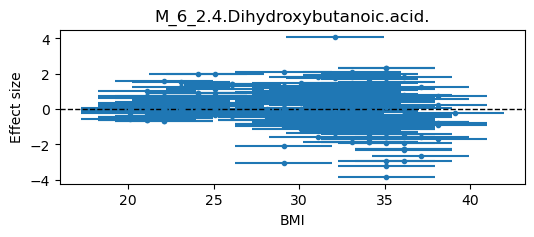

In [39]:
variable = X_name[0]
modifier = "BMI"
no_effect_value = 0
errorbar = 'y'
ESPClust.Eff_size_Windows_plot(esp_df,variable,modifier,no_effect_value,errorbar)

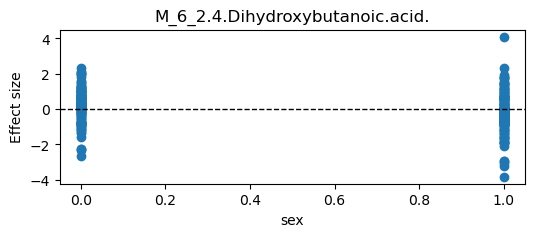

In [43]:
variable = X_name[0]
modifier = "sex"
no_effect_value = 0
errorbar = 'n'
ESPClust.Eff_size_Windows_plot(esp_df,variable,modifier,no_effect_value,errorbar)

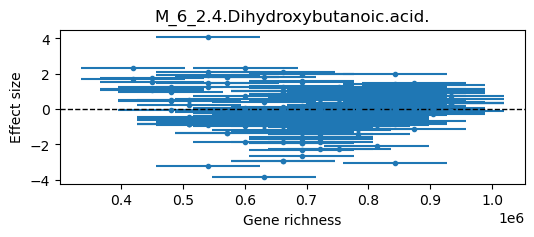

In [45]:
variable = X_name[0]
modifier = "Gene richness"
no_effect_value = 0
errorbar = 'y'
ESPClust.Eff_size_Windows_plot(esp_df,variable,modifier,no_effect_value,errorbar)

### Clustering of windows according to their ESP

ESPClust provides several functions to analyse the clustering of windows

#### Clustering indices

The function `Clustering_indices` four clustering measures as a function of the number of clusters ($k \in \{2,3,\dots,k_{\max}\}$): Calinski-Harabasz, Davies-Bouldin, silhouette and inertia. 

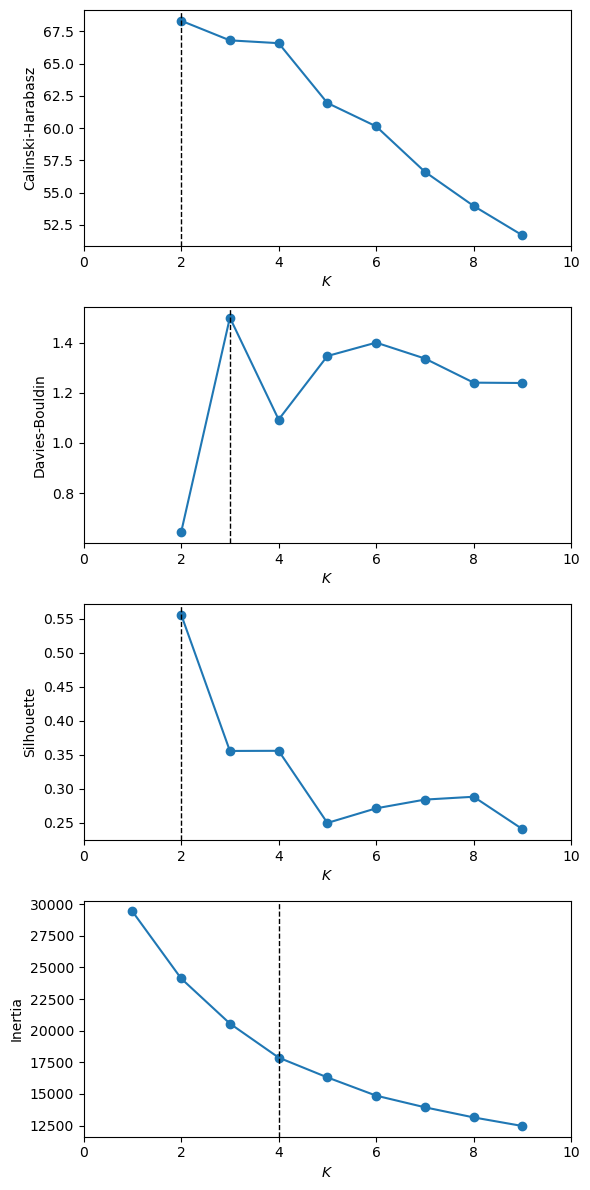

In [43]:
features_df = esp_df[X_name]
kmax = 10
cluster_method = "Agglomerate"  #"Kmeans"
plotYN = 'y'
index_vs_K_df,KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall = ESPClust.Clustering_indices(features_df,kmax,cluster_method,plotYN)

##### Outputs of `Clustering_indices`

- If `plotYN = "Y"`, the function `Clustering_indices` provides a plot for each of the clustering measures as a function of the number of clusters. A vertical dashed line indicates the optimal number of clusters for each of the measures.

- `Clustering_indices` provides a dataframe with the value of the clustering measures as a function of the number of clusters:

In [55]:
index_vs_K_df

,k,CH,DB,Sil,inertia
0,1,NaN,NaN,NaN,29422.000000
1,2,68.330809,0.643520,0.556466,24122.063876
2,3,66.809551,1.500622,0.355673,20560.025353
3,4,66.591175,1.093436,0.355888,17869.243529
4,5,61.955420,1.347235,0.249722,16303.746947
5,6,60.145466,1.400819,0.271241,14862.839939
6,7,56.623640,1.337266,0.284086,13942.308618
7,8,53.975755,1.240886,0.288273,13141.933180
8,9,51.701130,1.239489,0.240669,12464.012497


- `Clustering_indices` also gives the optimal value of the number of clusters according to each of the clustering measures and the overall optimal:

In [54]:
KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall

(2, 3, 2, 4, 2, 2)

#### Testing the statistical significance of `koptimal_overall` compared to a non-clustered data null hypothesis (no effect modification)

The function `Elbow_significance` tests the optimal number of clusters from the previous step against a dataset with uniform effect sizes without cluster structure:

In [45]:
nref = 2000 #2000  # Number of reference uniform datasets (2000)
kmax = 10
cluster_method = "Agglomerate"  # Or "Kmeans"
plotYN = 'y'
alpha=0.001

data = esp_df[X_name] #esp_df[X_name] #x_pca[:,:10] #x_pca #features_df #x_pca
    
features_df = data
k_test = koptimal_overall
DeltaObs, percentile, p_value, koptimal_overall2, reject_null = ESPClust.Elbow_significance(features_df,k_test,nref,cluster_method,alpha)
DeltaObs, percentile, p_value, koptimal_overall2, reject_null

(0.487894106274656, 0.2563012781548154, 0.0, 2, True)

In [ ]:
KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall,koptimal_overall2

#### Principal component visualisation of the clusters in the effect size space

The clustering of effect size windows can be visualised with `ESP_pca` using principal component analysis.

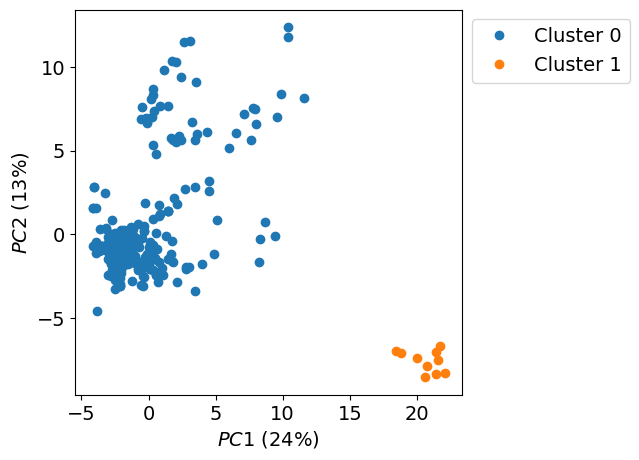

In [47]:
features_df = esp_df[X_name] 
n_clusters = koptimal_overall2 # Number of clusters to be coloured differently
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
pcomp_1=1 
pcomp_2=2
plotYN = "y"

x_pca,cumVar = ESPClust.ESP_pca(features_df,cluster_method,plotYN,pcomp_1,pcomp_2,n_clusters,clusterOrder)

##### Outputs

* If `plotYN = "y"`, a plot of the window lusters in the space spanned by the two selected principal components.
* `x_pca`: Coordinates of the projection of each feature on the principal component directions. 
* `cumVar`: array giving the cumulative explained variance for the principal components.

In [65]:
x_pca

array([[-2.39986531, -0.5577414 ,  1.16357687, ...,  0.04531926,
         0.07431099, -0.01908169],
       [-2.74854613, -0.9422535 ,  0.07730277, ...,  0.12540859,
        -0.01245817,  0.03069469],
       [-2.91867416, -1.13035567, -0.30931952, ..., -0.04552063,
        -0.0431605 , -0.0478115 ],
       ...,
       [ 0.86601281,  7.63954642, -5.93337592, ..., -0.06741333,
         0.0161108 , -0.07617237],
       [ 1.45447175,  7.65056526, -3.77629411, ..., -0.01733836,
         0.11973552,  0.02977068],
       [-3.18870667,  0.3349346 , -1.41708956, ...,  0.19738297,
        -0.08298296,  0.06170065]])

In [67]:
cumVar

array([0.23924371, 0.36584737, 0.47880585, 0.55873477, 0.61002256,
       0.65621444, 0.69720638, 0.73138678, 0.75837974, 0.78324168,
       0.80382248, 0.82016797, 0.83546703, 0.84892823, 0.86049523,
       0.87145531, 0.8811974 , 0.88951344, 0.89719143, 0.90444635,
       0.91116414, 0.91701794, 0.92256349, 0.92794452, 0.93272782,
       0.93681743, 0.94075991, 0.94448698, 0.94781775, 0.95099201,
       0.95396372, 0.95689747, 0.95935473, 0.96174311, 0.96405213,
       0.96617077, 0.9681658 , 0.97006727, 0.9718984 , 0.9736424 ,
       0.97526866, 0.97681747, 0.97820985, 0.97949674, 0.9807643 ,
       0.98197401, 0.98306022, 0.98411497, 0.98509203, 0.98601007,
       0.98685782, 0.98768667, 0.98846435, 0.98923027, 0.98993529,
       0.99056622, 0.99117139, 0.99173656, 0.99227886, 0.99280778,
       0.99329064, 0.99375367, 0.99417935, 0.99459856, 0.99498449,
       0.99534979, 0.99570156, 0.99604954, 0.9963629 , 0.99665978,
       0.99694208, 0.99717897, 0.9974102 , 0.99763535, 0.99784

#### Cluster label of each window

The function `Window_clusters_labels` finds clusters and assign a label to each cluster. It returns the cluster label for each window.

In [69]:
#------------------------------------
## ---- Labels of window clusters
#------------------------------------
n_clusters = koptimal_overall2
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
features_df = esp_df[X_name]
labels = ESPClust.Window_clusters_labels(features_df,n_clusters,cluster_method,clusterOrder)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Plot of the clusters in the covariate space

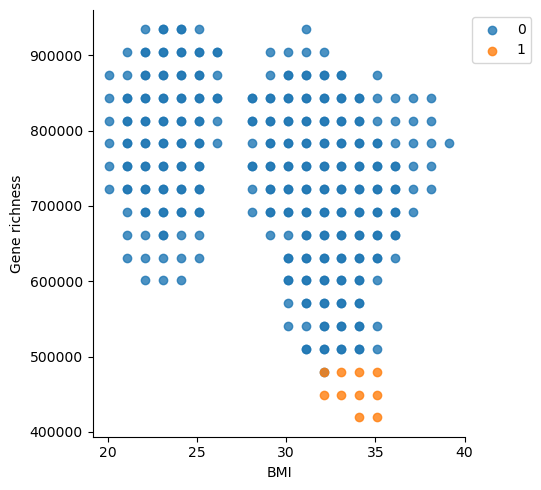

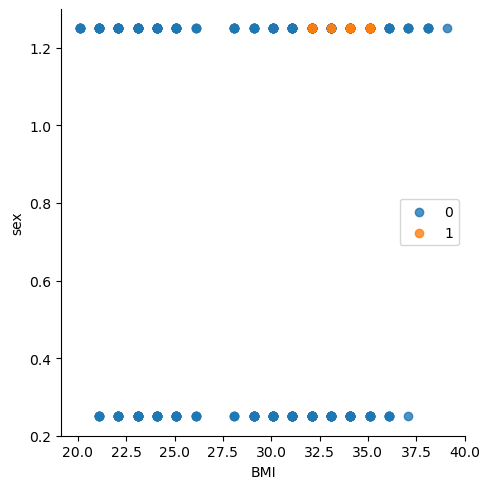

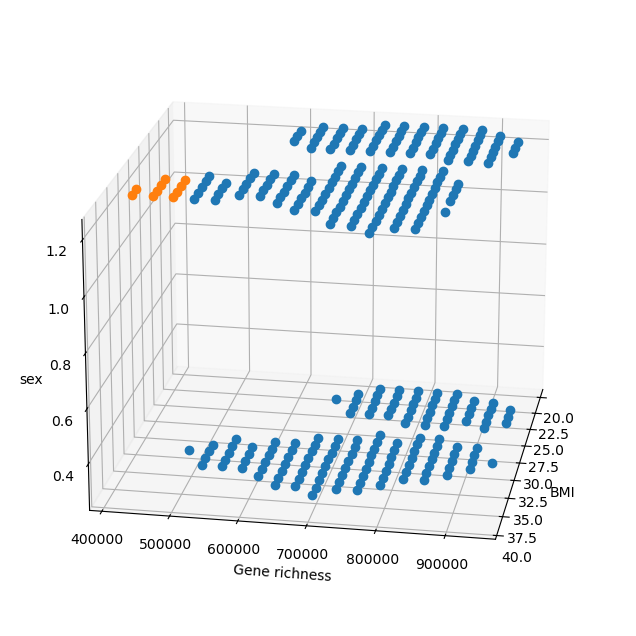

In [37]:
n_clusters = koptimal_overall2
clusterOrder=[0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
#%matplotlib widget
#%matplotlib inline
labelsDF = ESPClust.plot_clusters_CovSpace(esp_df,X_name,modifier_names,n_clusters,cluster_method,clusterOrder,L)

#### Cluster centroids

The coordinates of the centroids of the clusters, their dispersion and inertia of the clustering are provided by the function `Window_cluster_centroids`. 

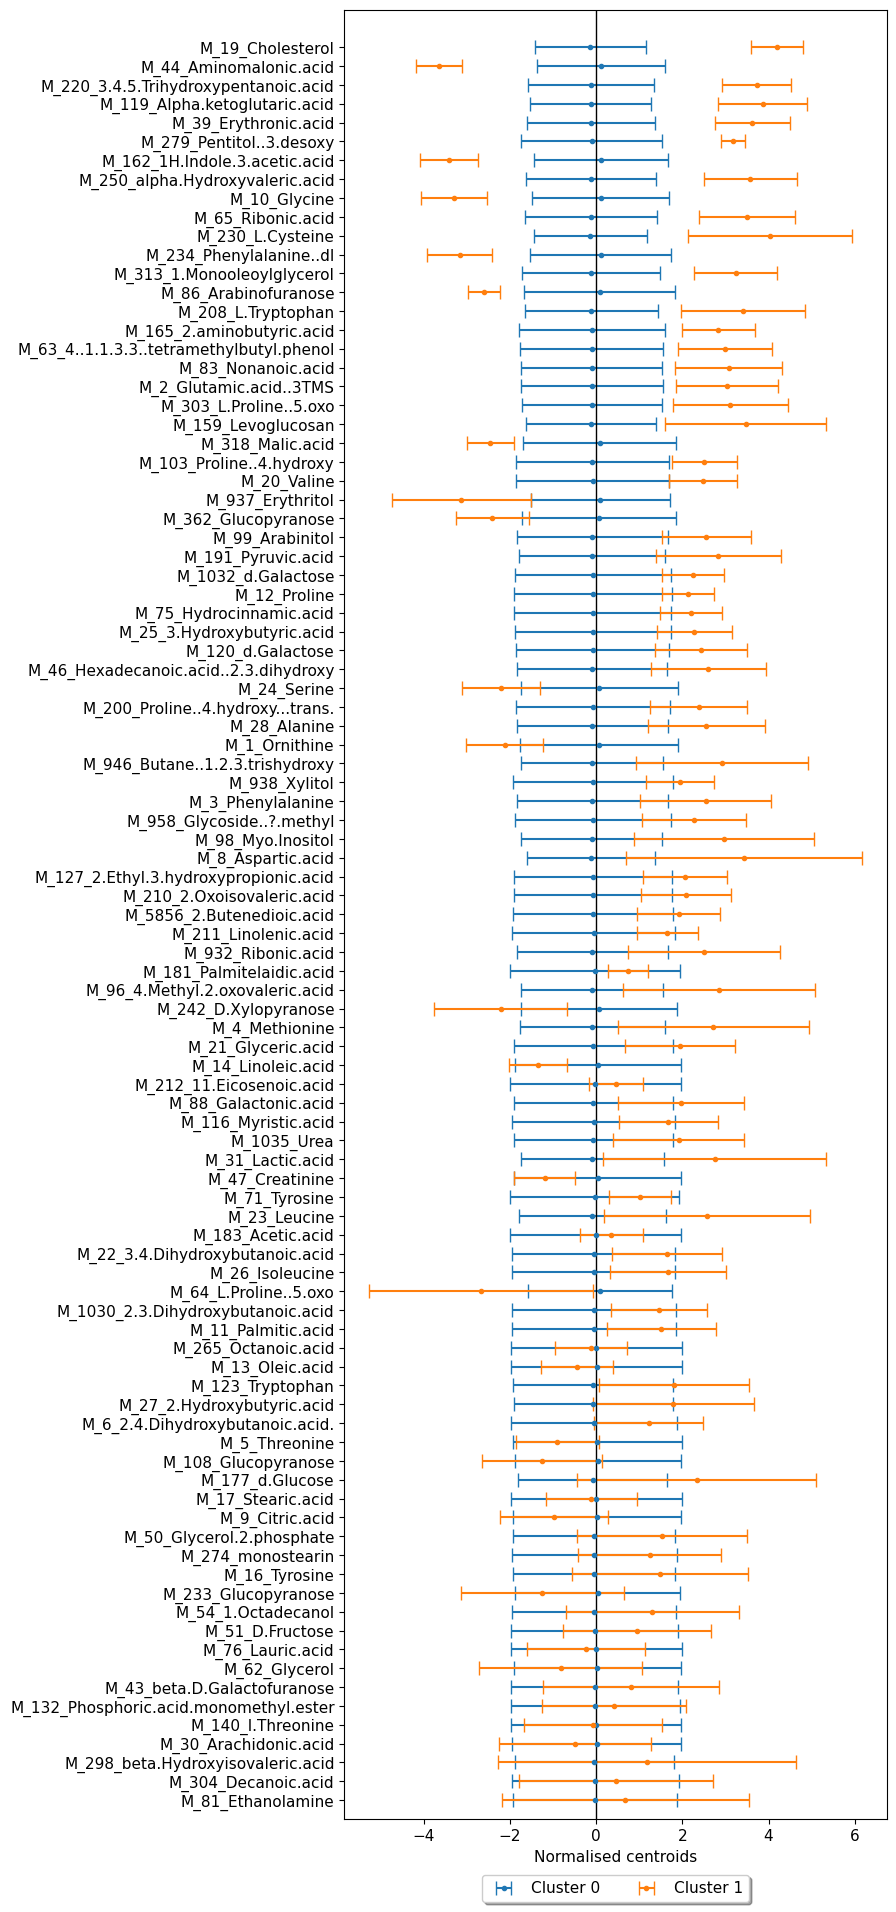

In [42]:
features_df = esp_df[X_name]
n_clusters = koptimal_overall2
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"

plot = 'errorbar' #'errorbar' #'none' #'lines', 'points', 'points-lines' #'errorbar'
scale_ErrorSD = 1.96
diff_sorted = "Y"

centroids,centroids_SD,inertia = ESPClust.Window_cluster_centroids(features_df,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)

##### Outputs of `Window_cluster_centroids`

In [75]:
centroids

,M_81_Ethanolamine,M_304_Decanoic.acid,M_298_beta.Hydroxyisovaleric.acid,M_30_Arachidonic.acid,M_140_l.Threonine,M_132_Phosphoric.acid.monomethyl.ester,M_43_beta.D.Galactofuranose,M_62_Glycerol,M_76_Lauric.acid,M_51_D.Fructose,...,M_65_Ribonic.acid,M_10_Glycine,M_250_alpha.Hydroxyvaleric.acid,M_162_1H.Indole.3.acetic.acid,M_279_Pentitol..3.desoxy,M_39_Erythronic.acid,M_119_Alpha.ketoglutaric.acid,M_220_3.4.5.Trihydroxypentanoic.acid,M_44_Aminomalonic.acid,M_19_Cholesterol
0,-0.022498,-0.015018,-0.039156,0.015910,0.002449,-0.013693,-0.026783,0.027149,0.007573,-0.031312,...,-0.115467,0.108798,-0.118208,0.112301,-0.104817,-0.119659,-0.127529,-0.122952,0.120385,-0.138262
1,0.681704,0.455052,1.186429,-0.482073,-0.074209,0.414890,0.811512,-0.822609,-0.229476,0.948739,...,3.498656,-3.296568,3.581690,-3.402711,3.175970,3.625663,3.864123,3.725446,-3.647667,4.189330


In [77]:
centroids_SD

,M_81_Ethanolamine,M_304_Decanoic.acid,M_298_beta.Hydroxyisovaleric.acid,M_30_Arachidonic.acid,M_140_l.Threonine,M_132_Phosphoric.acid.monomethyl.ester,M_43_beta.D.Galactofuranose,M_62_Glycerol,M_76_Lauric.acid,M_51_D.Fructose,...,M_65_Ribonic.acid,M_10_Glycine,M_250_alpha.Hydroxyvaleric.acid,M_162_1H.Indole.3.acetic.acid,M_279_Pentitol..3.desoxy,M_39_Erythronic.acid,M_119_Alpha.ketoglutaric.acid,M_220_3.4.5.Trihydroxypentanoic.acid,M_44_Aminomalonic.acid,M_19_Cholesterol
0,0.972800,0.991172,0.939217,0.999271,1.005370,1.001615,0.987423,0.989433,1.007486,0.988422,...,0.777899,0.810794,0.765306,0.796504,0.829736,0.760435,0.717467,0.744566,0.759569,0.656949
1,1.464875,1.148348,1.765634,0.896709,0.817311,0.851004,1.037819,0.968471,0.700187,0.876213,...,0.565762,0.393915,0.549189,0.341388,0.141106,0.446535,0.527793,0.406595,0.271926,0.305555


In [79]:
inertia

24122.063875601456

## More figures - Used in the paper

In [75]:
dfout = esp_df

### Covariate space clustering plots for each sex

In [49]:
#from matplotlib.path import Path

from matplotlib.patches import Rectangle

def plot_clusters_EffModSpace_2D_male(dfout0,X_name,modifier_names,n_clusters,cluster_method,clusterOrder,xtitle,xmin,xmax,ytitle,ymin,ymax,L):
    from matplotlib.patches import Rectangle
    distance = dfout0[X_name]
    labels0 = ESPClust.Window_clusters_labels(distance,n_clusters,cluster_method,clusterOrder)
        
    dfout = dfout0[dfout0['sex_z0']==0]
    labels = labels0[dfout0['sex_z0']==0]
    
    factor_z=1e-6
        
    #rect = plt.Rectangle((left, bottom), width, height, facecolor="black", alpha=0.1)
    
    #plt.figure(figsize=(2,6))
    
    #ax.set_rcParams['font.size'] = 14.
    font = {'size'   : 15}
    plt.rc('font', **font)
    labelsDF = pd.DataFrame({modifier_names[0]: dfout[modifier_names[0]+'_z0']+L[0]/2, modifier_names[1]: (dfout[modifier_names[1]+'_z0']+L[1]/2)*factor_z, 'Cluster': labels})
    
    fg = sns.lmplot(x=modifier_names[0], y=modifier_names[1], data=labelsDF, fit_reg=False, hue='Cluster', legend=False,height=5, aspect=0.8)
    #plt.add_patch(rect)
    left = xmin+1
    bottom = ymin+0.01
    width = L[0]
    height = L[1]*factor_z
    
    # Window
    fg.axes[0, 0].add_patch(Rectangle((left, bottom), width, height, fill=True, facecolor="black", alpha=0.2,edgecolor='black',lw=0))
    fg.axes[0, 0].add_patch(Rectangle((left, bottom), width, height, fill=False, facecolor="black", alpha=1.0,edgecolor='black',lw=1,linestyle = '--'))

    fg.axes[0, 0].set_xlim([xmin,xmax])
    fg.axes[0, 0].set_ylim([ymin,ymax])
    fg.axes[0, 0].set_xlabel(xtitle, fontsize=15)
    fg.axes[0, 0].set_ylabel(ytitle, fontsize=15)
    #fg.axes[0, 0].set_xticks([15,20,25,30,35])
    fg.axes[0, 0].set_title("Male")

    return labelsDF

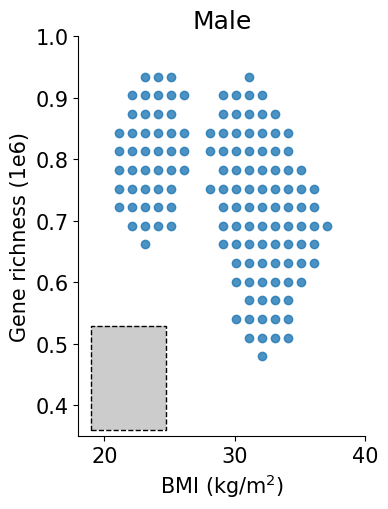

In [51]:
xtitle="BMI (kg/m$^2$)"
xmin = 18
xmax = 40
ytitle="Gene richness (1e6)"
ymin = 0.35
ymax = 1.0
labelsDF = plot_clusters_EffModSpace_2D_male(esp_df,X_name,modifier_names,n_clusters,cluster_method,clusterOrder,xtitle,xmin,xmax,ytitle,ymin,ymax,L)

In [53]:
def plot_clusters_EffModSpace_2D_female(dfout0,X_name,modifier_names,n_clusters,cluster_method,clusterOrder,xtitle,xmin,xmax,ytitle,ymin,ymax,L):
    from matplotlib.patches import Rectangle
    distance = dfout0[X_name]
    labels0 = ESPClust.Window_clusters_labels(distance,n_clusters,cluster_method,clusterOrder)
        
    dfout = dfout0[dfout0['sex_z0']==1]
    labels = labels0[dfout0['sex_z0']==1]
    
    factor_z=1e-6
        
    #rect = plt.Rectangle((left, bottom), width, height, facecolor="black", alpha=0.1)
    
    #plt.figure(figsize=(2,6))
    
    #ax.set_rcParams['font.size'] = 14.
    font = {'size'   : 15}
    plt.rc('font', **font)
    labelsDF = pd.DataFrame({modifier_names[0]: dfout[modifier_names[0]+'_z0']+L[0]/2, modifier_names[1]: (dfout[modifier_names[1]+'_z0']+L[1]/2)*factor_z, 'Cluster': labels})
    
    fg = sns.lmplot(x=modifier_names[0], y=modifier_names[1], data=labelsDF, fit_reg=False, hue='Cluster', legend=False,height=5, aspect=0.8)
    #plt.add_patch(rect)
    left = xmin+1
    bottom = ymin+0.01
    width = L[0]
    height = L[1]*factor_z
    
    # Window
    #fg.axes[0, 0].add_patch(Rectangle((left, bottom), width, height, fill=True, facecolor="black", alpha=0.2,edgecolor='black',lw=0))
    #fg.axes[0, 0].add_patch(Rectangle((left, bottom), width, height, fill=False, facecolor="black", alpha=1.0,edgecolor='black',lw=1,linestyle = '--'))

    fg.axes[0, 0].set_xlim([xmin,xmax])
    fg.axes[0, 0].set_ylim([ymin,ymax])
    fg.axes[0, 0].set_xlabel(xtitle, fontsize=15)
    fg.axes[0, 0].set_ylabel(ytitle, fontsize=15)
    #fg.axes[0, 0].set_xticks([15,20,25,30,35])
    fg.axes[0, 0].set_title("Female")

    return labelsDF

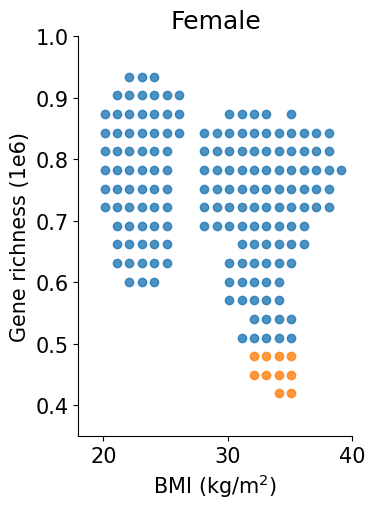

In [55]:
labelsDF = plot_clusters_EffModSpace_2D_female(esp_df,X_name,modifier_names,n_clusters,cluster_method,clusterOrder,xtitle,xmin,xmax,ytitle,ymin,ymax,L)

### Centres plots

In [61]:
features_df = esp_df[X_name]
n_clusters = koptimal_overall2
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"

plot = 'none' #'errorbar' #'none' #'lines', 'points', 'points-lines' #'errorbar'
scale_ErrorSD = 1.96
diff_sorted = "N"

centres,centres_SD,inertia = ESPClust.Window_cluster_centroids(features_df,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)

#Window_cluster_centroids(features,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)
#Window_cluster_centroids(distance,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)
sorted_total_overlap, index_sorted_total_overlap = ESPClust.total_overlap(centres,centres_SD,scale_ErrorSD)

distance2 = features_df[features_df.columns[index_sorted_total_overlap]]

centres2,centres_SD2,inertia2 = ESPClust.Window_cluster_centroids(distance2,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)

In [63]:
def Window_cluster_centres_plot_local(centres,centres_SD,scale_ErrorSD,plotType):
    X_name = centres.columns

    fig_width = 4
    if plotType == 'lines':
        font = {'size'   : 11}
        plt.rc('font', **font)

        verticalD = max([4.,len(X_name)/4.])
        fig, ax = plt.subplots(figsize=(fig_width, verticalD))

        #centres = kmeans.cluster_centers_

        #ax.hlines(metsgroup,centres[0],np.zeros(len(centres[0])),colors='y')
        #ax.hlines(metsgroup,centres[1],np.zeros(len(centres[0])),colors='b')
        for i in range(centres.shape[0]):
            ax.plot(centres.loc[i],X_name,'-',label='Cluster '+str(i),markersize=10)

        ax.axvline(x = 0, color = 'black', ls='-', lw=1)
        ax.set_xlabel('Normalized centroids')
        ax.set_ylim([-1,len(X_name)+1])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),fancybox=True, shadow=True, ncol=5)
    
    if plotType == 'points':
        font = {'size'   : 11}
        plt.rc('font', **font)

        verticalD = max([4.,len(X_name)/4.])
        fig, ax = plt.subplots(figsize=(fig_width, verticalD))

        #centres = kmeans.cluster_centers_

        #ax.hlines(metsgroup,centres[0],np.zeros(len(centres[0])),colors='y')
        #ax.hlines(metsgroup,centres[1],np.zeros(len(centres[0])),colors='b')
        for i in range(centres.shape[0]):
            ax.plot(centres.loc[i],X_name,'o',label='Cluster '+str(i),markersize=10)

        ax.axvline(x = 0, color = 'black', ls='-', lw=1)
        ax.set_xlabel('Normalized centroids')
        ax.set_ylim([-1,len(X_name)+1])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),fancybox=True, shadow=True, ncol=5)
 
    if plotType == 'points-lines':
        font = {'size'   : 11}
        plt.rc('font', **font)

        verticalD = max([4.,len(X_name)/4.])
        fig, ax = plt.subplots(figsize=(fig_width, verticalD))

        #centres = kmeans.cluster_centers_

        #ax.hlines(metsgroup,centres[0],np.zeros(len(centres[0])),colors='y')
        #ax.hlines(metsgroup,centres[1],np.zeros(len(centres[0])),colors='b')
        for i in range(centres.shape[0]):
            ax.plot(centres.loc[i],X_name,'o-',label='Cluster '+str(i),markersize=10)

        ax.axvline(x = 0, color = 'black', ls='-', lw=1)
        ax.set_xlabel('Normalized centroids')
        ax.set_ylim([-1,len(X_name)+1])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),fancybox=True, shadow=True, ncol=5)
 
    
    if plotType == 'errorbar':
        font = {'size'   : 11}
        plt.rc('font', **font)

        verticalD = max([4.,len(X_name)/4.])
        fig, ax = plt.subplots(figsize=(fig_width, verticalD))

        #centres = kmeans.cluster_centers_

        #ax.hlines(metsgroup,centres[0],np.zeros(len(centres[0])),colors='y')
        #ax.hlines(metsgroup,centres[1],np.zeros(len(centres[0])),colors='b')
        for i in range(centres.shape[0]):
            #ax.plot(centres[i],X_name,'-o',label='Cluster '+str(i),markersize=10)
            ax.errorbar(centres.loc[i],X_name,xerr=scale_ErrorSD*centres_SD.loc[i],fmt='.',label='Cluster '+str(i),capsize=5)

        ax.axvline(x = 0, color = 'black', ls='-', lw=1)
        ax.set_xlabel('Normalized centroids', fontsize=14)
        ax.set_ylim([-1,len(X_name)+1])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -2.5/centres.shape[1]),fancybox=True, shadow=True, ncol=5)


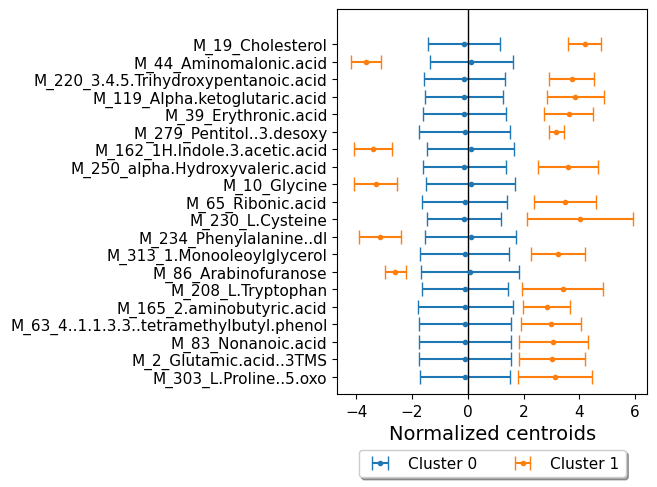

In [65]:
plotType = 'errorbar' #'lines', 'points', 'points-lines' or 'errorbar'

X_name2 = distance2.columns
scale_ErrorSD = 1.96
Window_cluster_centres_plot_local(centres2[X_name2[-20:]],centres_SD2[X_name2[-20:]],scale_ErrorSD,plotType)

### Stratification - Effect sizes in different groups

#### 2 clusters

In [61]:
data.columns

Index(['M_6_2.4.Dihydroxybutanoic.acid.', 'M_27_2.Hydroxybutyric.acid',
       'M_22_3.4.Dihydroxybutanoic.acid', 'M_25_3.Hydroxybutyric.acid',
       'M_28_Alanine', 'M_30_Arachidonic.acid', 'M_8_Aspartic.acid',
       'M_19_Cholesterol', 'M_9_Citric.acid', 'M_2_Glutamic.acid..3TMS',
       'M_21_Glyceric.acid', 'M_10_Glycine', 'M_26_Isoleucine', 'M_23_Leucine',
       'M_14_Linoleic.acid', 'M_4_Methionine', 'M_13_Oleic.acid',
       'M_1_Ornithine', 'M_11_Palmitic.acid', 'M_3_Phenylalanine',
       'M_12_Proline', 'M_24_Serine', 'M_17_Stearic.acid', 'M_5_Threonine',
       'M_16_Tyrosine', 'M_20_Valine', 'M_212_11.Eicosenoic.acid',
       'M_162_1H.Indole.3.acetic.acid', 'M_313_1.Monooleoylglycerol',
       'M_54_1.Octadecanol', 'M_1030_2.3.Dihydroxybutanoic.acid',
       'M_165_2.aminobutyric.acid', 'M_5856_2.Butenedioic.acid',
       'M_127_2.Ethyl.3.hydroxypropionic.acid', 'M_210_2.Oxoisovaleric.acid',
       'M_220_3.4.5.Trihydroxypentanoic.acid',
       'M_63_4..1.1.3.3..tetrame

In [82]:
featuresExtended['outcome']

0      3.0
1      2.6
2      0.7
3      1.4
4      2.1
      ... 
286    0.9
287    0.9
288    0.6
289    6.8
290    0.5
Name: outcome, Length: 275, dtype: float64

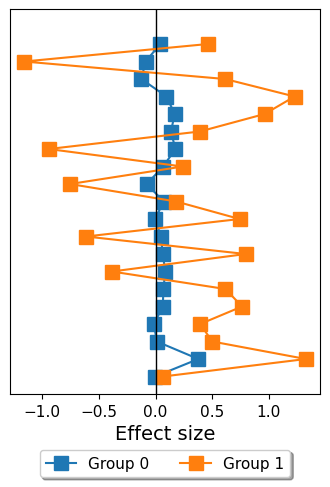

In [82]:
data = featuresExtended
BMI_l = 26
Generichness_h = 480000

X_name2 = X_name2 = distance2.columns #distance2.columns[-npanels:][::-1]
X_name_temp = X_name2[-20:]

alphasig = 1 #0.05
plot_yn = "y"

EffSize_clust_df_list = []
clust_index = []

# - Cluster of high gene richness and low BMI
c = 0
clust_index.append(c)

data_c = data.loc[~((data["BMI"] >= BMI_l) & (data["Gene richness"] <= Generichness_h))]

dataX = data_c[X_name_temp]
dataY = data_c["outcome"]

confounderIn=data_c[confound_names]
pvtlr,siglr, pvalBHlr, sigBH0lr, beta, ciL, ciH = ESPClust.LinSignificance(dataX,dataY,confounderIn,alphasig,'n')

dforsorted = pd.DataFrame({"met_name": siglr, "beta": beta, "ciL": ciL, "ciH": ciH})

EffSize_clust_df_list.append(dforsorted)

# - Cluster of low gene richness and high BMI
c = 1
clust_index.append(c)

data_c = data.loc[((data["BMI"] >= BMI_l) & (data["Gene richness"] <= Generichness_h))]

dataX = data_c[X_name_temp]
dataY = data_c["outcome"]

confounderIn=data_c[confound_names]
pvtlr,siglr, pvalBHlr, sigBH0lr, beta, ciL, ciH = ESPClust.LinSignificance(dataX,dataY,confounderIn,alphasig,'n')

dforsorted = pd.DataFrame({"met_name": siglr, "beta": beta, "ciL": ciL, "ciH": ciH})

EffSize_clust_df_list.append(dforsorted)

fig_width = 4
if (plotYN == 'Y') | (plotYN == 'y'):
    font = {'size'   : 11}
    plt.rc('font', **font)

    verticalD = max([4.,len(X_name_temp)/4.])
    fig, ax = plt.subplots(figsize=(fig_width, verticalD))

    #centres = kmeans.cluster_centers_

    #ax.hlines(metsgroup,centres[0],np.zeros(len(centres[0])),colors='y')
    #ax.hlines(metsgroup,centres[1],np.zeros(len(centres[0])),colors='b')
    for i in range(len(EffSize_clust_df_list)):
            ax.plot(EffSize_clust_df_list[i]["beta"],X_name_temp,'-s',label='Group '+str(clust_index[i]),markersize=10)
            #ax.plot(EffSize_clust_df_list[i]["beta"],X_name_temp,'s',label='Group '+str(clust_index[i]),markersize=10)
            #ax.errorbar(EffSize_clust_df_list[i]["beta"],X_name_temp,xerr=[EffSize_clust_df_list[i]["ciL"],EffSize_clust_df_list[i]["ciH"]],fmt='.',label='Group '+str(i))
        
    ax.axvline(x = 0, color = 'black', ls='-', lw=1)
    ax.set_xlabel('Effect size', fontsize=14)
    ax.set_ylim([-1,len(X_name_temp)+1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -2.5/len(X_name_temp)),fancybox=True, shadow=True, ncol=5)

    # disabling yticks by setting yticks to an empty list
    ax.set_yticks([])  

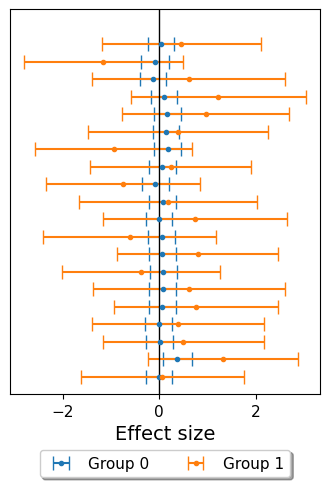

In [83]:
BMI_l = 26
Generichness_h = 480000

X_name2 = X_name2 = distance2.columns #distance2.columns[-npanels:][::-1]
X_name_temp = X_name2[-20:]

alphasig = 1 #0.05
plot_yn = "y"

EffSize_clust_df_list = []
clust_index = []

# - Cluster of high gene richness and low BMI
c = 0
clust_index.append(c)

data_c = data.loc[~((data["BMI"] >= BMI_l) & (data["Gene richness"] <= Generichness_h))]

dataX = data_c[X_name_temp]
dataY = data_c["outcome"]

confounderIn=data_c[confound_names]
pvtlr,siglr, pvalBHlr, sigBH0lr, beta, ciL, ciH = ESPClust.LinSignificance(dataX,dataY,confounderIn,alphasig,'n')

dforsorted = pd.DataFrame({"met_name": siglr, "beta": beta, "ciL": ciL, "ciH": ciH})

EffSize_clust_df_list.append(dforsorted)

# - Cluster of low gene richness and high BMI
c = 1
clust_index.append(c)

data_c = data.loc[((data["BMI"] >= BMI_l) & (data["Gene richness"] <= Generichness_h))]

dataX = data_c[X_name_temp]
dataY = data_c["outcome"]

confounderIn=data_c[confound_names]
pvtlr,siglr, pvalBHlr, sigBH0lr, beta, ciL, ciH = ESPClust.LinSignificance(dataX,dataY,confounderIn,alphasig,'n')

dforsorted = pd.DataFrame({"met_name": siglr, "beta": beta, "ciL": ciL, "ciH": ciH})

EffSize_clust_df_list.append(dforsorted)

fig_width = 4
if (plotYN == 'Y') | (plotYN == 'y'):
    font = {'size'   : 11}
    plt.rc('font', **font)

    verticalD = max([4.,len(X_name_temp)/4.])
    fig, ax = plt.subplots(figsize=(fig_width, verticalD))

    #centres = kmeans.cluster_centers_

    #ax.hlines(metsgroup,centres[0],np.zeros(len(centres[0])),colors='y')
    #ax.hlines(metsgroup,centres[1],np.zeros(len(centres[0])),colors='b')
    for i in range(len(EffSize_clust_df_list)):
            #ax.plot(EffSize_clust_df_list[i]["beta"],X_name_temp,'-s',label='Group '+str(clust_index[i]),markersize=10)
            #ax.plot(EffSize_clust_df_list[i]["beta"],X_name_temp,'s',label='Group '+str(clust_index[i]),markersize=10)
            ax.errorbar(EffSize_clust_df_list[i]["beta"],X_name_temp,xerr=[EffSize_clust_df_list[i]["ciL"],EffSize_clust_df_list[i]["ciH"]],fmt='.',label='Group '+str(i),capsize=5)
        
    ax.axvline(x = 0, color = 'black', ls='-', lw=1)
    ax.set_xlabel('Effect size', fontsize=14)
    ax.set_ylim([-1,len(X_name_temp)+1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -2.5/len(X_name_temp)),fancybox=True, shadow=True, ncol=5)

    # disabling yticks by setting yticks to an empty list
    ax.set_yticks([])  

### Plots of effect sizes in windows

#### 2 clusters

In [77]:
features_df = esp_df[X_name]
n_clusters = 2 #koptimal_overall2
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"

plot = 'none' #'errorbar' #'none' #'lines', 'points', 'points-lines' #'errorbar'
scale_ErrorSD = 1.96
diff_sorted = "N"

centres,centres_SD,inertia = ESPClust.Window_cluster_centroids(features_df,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)

#Window_cluster_centroids(features,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)
#Window_cluster_centroids(distance,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)
sorted_total_overlap, index_sorted_total_overlap = ESPClust.total_overlap(centres,centres_SD,scale_ErrorSD)

distance2 = features_df[features_df.columns[index_sorted_total_overlap]]

centres2,centres_SD2,inertia2 = ESPClust.Window_cluster_centroids(distance2,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)

In [79]:
def Eff_size_Windows_plot_local(dfout,variable,modifier,no_effect_value,errorbar,xmin,xmax,xtitle,ytitle):
    xerrlow =  dfout[modifier+'_z0'] #np.array(w00_list)
    xerrhigh = dfout[modifier+'_z0']+dfout[modifier+'_Lw'] #np.array(w00_list)+np.array(Lw[0])[m0_list]
    x = (xerrlow+xerrhigh)/2 #5/2
    y = dfout[variable] #Eff_table_1d[:,20]

    fig = plt.figure(figsize=(6, 2))
    
    if (errorbar == 'n') | (errorbar == 'N'):
        plt.plot(xerrlow,y,'o')
        plt.axhline(y = no_effect_value, color = 'black', ls='--', lw=1, label = 'axvline - full height')    
    elif (errorbar == 'y') | (errorbar == 'Y'):
        #plt.errorbar(x,y,xerr=[np.array(Lw[0])[m0_list]/2,np.array(Lw[0])[m0_list]/2],fmt='.')
        plt.errorbar(x,y,xerr=[dfout[modifier+'_Lw']/2,dfout[modifier+'_Lw']/2],fmt='.')
        plt.axhline(y = no_effect_value, color = 'black', ls='--', lw=1, label = 'axvline - full height')
    else:
        print('Specify if the error bars are to be plotted')

    
    plt.xlabel(xtitle,fontsize=14)
    plt.ylabel(ytitle,fontsize=14)
    #plt.title(variable)
    plt.ylim([xmin, xmax])

In [81]:
X_name2 = distance2.columns
met_index = -2 # most significant
X_name2[met_index]

'M_44_Aminomalonic.acid'

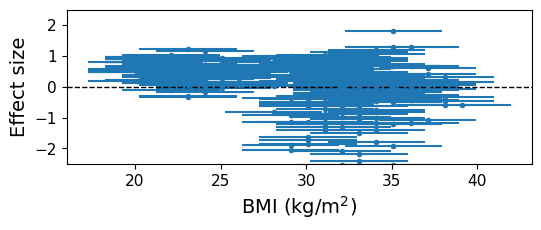

In [83]:
variable = X_name2[met_index]
modifier = 'BMI'
errorbar = 'y'
no_effect_value = 0
#%matplotlib inline
xtitle="BMI (kg/m$^2$)"
ytitle="Effect size"
#Eff_size_Windows_plot(dfout,variable,modifier,errorbar)
Eff_size_Windows_plot_local(dfout,variable,modifier,no_effect_value,errorbar,-2.5,2.5,xtitle,ytitle)

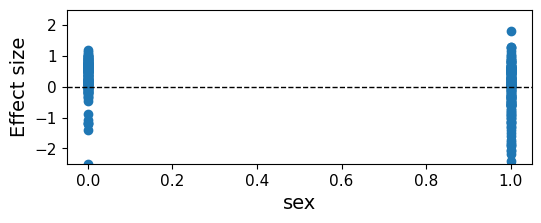

In [85]:
variable = X_name2[met_index]
modifier = 'sex'
errorbar = 'n'
no_effect_value = 0
#%matplotlib inline
xtitle="sex"
ytitle="Effect size"
#Eff_size_Windows_plot(dfout,variable,modifier,errorbar)
Eff_size_Windows_plot_local(dfout,variable,modifier,no_effect_value,errorbar,-2.5,2.5,xtitle,ytitle)

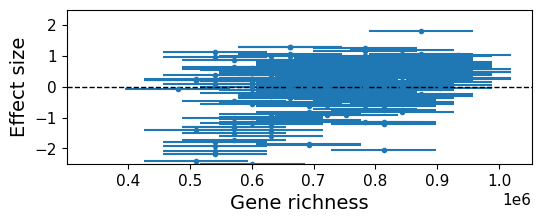

In [87]:
variable = X_name2[met_index]
modifier = 'Gene richness'
errorbar = 'y'
no_effect_value = 0
#%matplotlib inline
xtitle="Gene richness"
ytitle="Effect size"
#Eff_size_Windows_plot(dfout,variable,modifier,errorbar)
Eff_size_Windows_plot_local(dfout,variable,modifier,no_effect_value,errorbar,-2.5,2.5,xtitle,ytitle)

In [89]:
met_index = 1 # most significant
X_name2[met_index]

'M_304_Decanoic.acid'

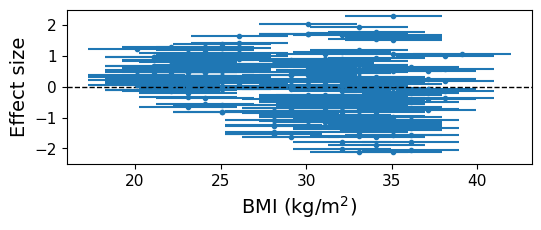

In [91]:
variable = X_name2[met_index]
modifier = 'BMI'
errorbar = 'y'
no_effect_value = 0
#%matplotlib inline
xtitle="BMI (kg/m$^2$)"
ytitle="Effect size"
#Eff_size_Windows_plot(dfout,variable,modifier,errorbar)
Eff_size_Windows_plot_local(dfout,variable,modifier,no_effect_value,errorbar,-2.5,2.5,xtitle,ytitle)

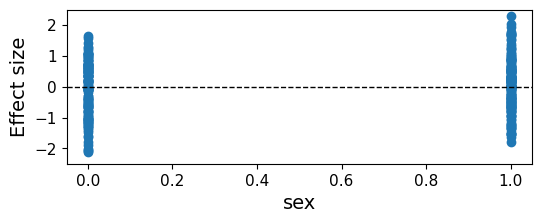

In [93]:
variable = X_name2[met_index]
modifier = 'sex'
errorbar = 'n'
no_effect_value = 0
#%matplotlib inline
xtitle="sex"
ytitle="Effect size"
#Eff_size_Windows_plot(dfout,variable,modifier,errorbar)
Eff_size_Windows_plot_local(dfout,variable,modifier,no_effect_value,errorbar,-2.5,2.5,xtitle,ytitle)

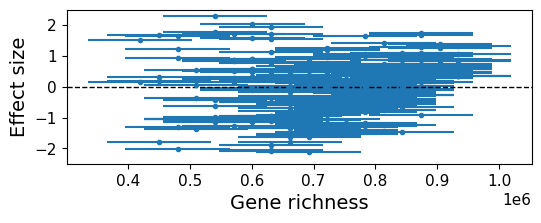

In [95]:
variable = X_name2[met_index]
modifier = 'Gene richness'
errorbar = 'y'
no_effect_value = 0
#%matplotlib inline
xtitle="Gene richness"
ytitle="Effect size"
#Eff_size_Windows_plot(dfout,variable,modifier,errorbar)
Eff_size_Windows_plot_local(dfout,variable,modifier,no_effect_value,errorbar,-2.5,2.5,xtitle,ytitle)

### Principal components

In [58]:
def pca_analysis(dfout,X_name,cluster_method,plot_yn,pcomp_1,pcomp_2,n_clusters,clusterOrder):
    from sklearn.decomposition import PCA
    distance = dfout[X_name]
    
    pca = PCA(n_components=len(distance.columns))
    
    # Scaled
    scaler = StandardScaler().fit(distance) # Define a standardisation scaler
    x_scaled = scaler.transform(distance) # Transform the data.
    X = x_scaled

    ## Not scaled
    #X = distance_measure

    x_pca = pca.fit(X).transform(X)

    cumVar = np.cumsum(pca.explained_variance_ratio_)
    
    if plot_yn == 'y':
        pc1 = pcomp_1
        pc2 = pcomp_2

        labels = ESPClust.Window_clusters_labels(distance,n_clusters,cluster_method,clusterOrder)

        fig = plt.figure(figsize=(5,5))
        font = {'size'   : 14}
        plt.rc('font', **font)

        if pc1==0:
            percent1 = 100*np.round(cumVar[pc1],2)
        else:
            percent1 = 100*np.round(cumVar[pc1],2)-100*np.round(cumVar[pc1-1],2)

        if pc2==0:
            percent2 = 100*np.round(cumVar[pc2],2)
        else:
            percent2 = 100*np.round(cumVar[pc2],2)-100*np.round(cumVar[pc2-1],2)

        for ic in range(n_clusters):
            plt.plot(x_pca[labels==ic,pc1],x_pca[labels==ic,pc2],'o',label = 'Cluster '+str(ic))

        plt.xlabel('$PC_1$'+' ('+str(int(percent1))+'%)')
        plt.ylabel('$PC_2$'+' ('+str(int(percent2))+'%)')
        #plt.xlim([-45,45])

        plt.legend()
    
    return x_pca,cumVar

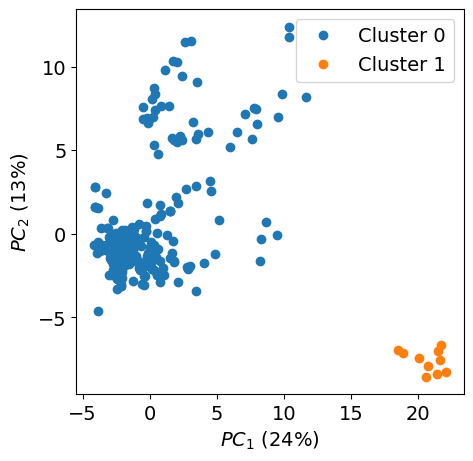

In [64]:
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
plot_yn='y'
pcomp_1=0
pcomp_2=1
n_clusters = 2
clusterOrder = [0,1]

x_pca,cumVar = pca_analysis(dfout,X_name,cluster_method,plot_yn,pcomp_1,pcomp_2,n_clusters,clusterOrder)